In [28]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
from statsmodels.tools.tools import add_constant
from scipy.interpolate import make_interp_spline

In [29]:
# 1. 데이터 불러오기
file_path ="AmesHousing.csv"
df = pd.read_csv(file_path)

결측치 처리

In [30]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

edited_df = df

#결측치 80%이상인경우 컬럼 삭제
missing_cols = missing.loc[(missing / len(df)) > 0.80].index
edited_df = edited_df.drop(columns=missing_cols)

missing_cols = missing.loc[(missing / len(df)) < 0.05].index
for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        #결측치 5%이하 범주형 변수 최빈값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].mode().iloc[0])
    else:
        #결측치 5%이하 수치형 변수 중앙값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].median())
        

#수치형은 MICE, 범주형은 'Missing'으로 결측치 채우기
missing_cols = missing.loc[(0.05 <= (missing / len(df))) & ((missing / len(df)) <= 0.80)].index

numeric_cols = edited_df.select_dtypes(include=['number']).columns

for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        edited_df[col] = edited_df[col].fillna('Missing')

#MICE Imputation(다중 대체)이용하여 결측치 제거
imputer = IterativeImputer(random_state=0)
edited_df[numeric_cols] = imputer.fit_transform(edited_df[numeric_cols])

타겟 변수 이진화

In [31]:
#상위 10% 기준 이진화 (premium house 예측)
threshold = edited_df['SalePrice'].quantile(0.90)
edited_df['target'] = (edited_df['SalePrice'] >= threshold).astype(int)

edited_df.drop('SalePrice', axis=1, inplace=True)

X = edited_df.drop('target', axis=1)
y = edited_df['target']

1번 방법 - 원 핫 인코딩 진행 후 모든 변수 다 때려넣기  

In [32]:
X_edited1 = pd.get_dummies(X, drop_first=True)

2번 방법 - 수치형 변수 중 타겟 변수와의 상관관계가 0.1이상인 변수를 선택하여 진행 

In [33]:
# 상관계수 기준 값 설정
CORR_THRESHOLD = 0.1  # 원하는 값으로 조정 가능

# 수치형 변수만 선택
numeric_df = edited_df.select_dtypes(include='number')

# 타겟 변수와 상관계수 계산
corr_with_target = numeric_df.corr()['target'].drop('target').abs()

# 기준 이상 변수만 선택
selected_features_corr = corr_with_target[corr_with_target >= CORR_THRESHOLD].index.tolist()

print(f"상관계수 {CORR_THRESHOLD} 이상 변수: ", selected_features_corr)

# 최종 변수 선택
X_edited2 = X[selected_features_corr]


상관계수 0.1 이상 변수:  ['PID', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF']


3번 방법 - Mutual Information 체크를 통해 MI가 0.05 이상인 변수를 선택하여 진행 (이 경우 범주형 변수 포함 가능)

In [34]:
# MI 기준 값 설정
MI_THRESHOLD = 0.01  # 원하는 값으로 조절 (보통 0.01 ~ 0.05 사이 추천)

df_mi = edited_df.copy()
cat_cols_all = df_mi.select_dtypes(include=['object']).columns

# 범주형 변수 Label Encoding
for col in cat_cols_all:
    df_mi[col] = LabelEncoder().fit_transform(df_mi[col])

# Mutual Information 계산
X_mi = df_mi.drop(columns=['target'])
y_mi = df_mi['target']

#수치형 / 범주형 구분
num_cols = X_mi.select_dtypes(exclude='object').columns
cat_cols = X_mi.select_dtypes(include='object').columns

# 각 feature가 discrete인지 여부 리스트 생성
discrete_flags = [True if col in cat_cols else False for col in X_mi.columns]

mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features=discrete_flags, random_state=42)
mi_result = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

# MI 기준 이상 변수 선택
selected_features_MI = mi_result[mi_result >= MI_THRESHOLD].index.tolist()

print(f"MI {MI_THRESHOLD} 이상 변수: ", selected_features_MI)

# 수치형 / 범주형 분리
num_cols = df[selected_features_MI].select_dtypes(exclude='object').columns.tolist()
cat_cols = df[selected_features_MI].select_dtypes(include='object').columns.tolist()

# 범주형 변수 One-Hot Encoding
df_cat_encoded = pd.get_dummies(edited_df[cat_cols], drop_first=True)

# 최종 X 데이터 구성
X_edited3 = pd.concat([edited_df[num_cols], df_cat_encoded], axis=1)


MI 0.01 이상 변수:  ['PID', 'Overall Qual', 'Order', 'Neighborhood', 'Garage Cars', 'Garage Area', 'Bsmt Qual', 'Exter Qual', 'Kitchen Qual', 'Gr Liv Area', '1st Flr SF', 'Total Bsmt SF', 'Year Built', 'BsmtFin SF 1', 'Fireplace Qu', 'Mas Vnr Area', 'Year Remod/Add', 'Garage Yr Blt', 'TotRms AbvGrd', 'Lot Frontage', 'Foundation', 'Lot Area', 'Garage Finish', 'Mas Vnr Type', 'Open Porch SF', 'Full Bath', '2nd Flr SF', 'Fireplaces', 'MS SubClass', 'Heating QC', 'BsmtFin Type 1', 'Bsmt Exposure', 'Exterior 2nd', 'Roof Style', 'Sale Condition', 'Overall Cond', 'Sale Type', 'Garage Type', 'Wood Deck SF', 'Exterior 1st', 'Bsmt Full Bath', 'House Style', 'MS Zoning', 'Land Contour', 'Condition 2', 'Bsmt Unf SF', 'Kitchen AbvGr', 'Lot Shape', 'Garage Qual', 'Bedroom AbvGr', 'Garage Cond', 'Exter Cond', 'Central Air', 'Electrical']


1번에 대한 결과

In [35]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test1, y_train, y_test = train_test_split(
    X_edited1, y, test_size=0.2, random_state=42, stratify=y
)

model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

odds_ratios = pd.Series(np.exp(model1.coef_[0]), index=X_edited1.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model1.predict(X_test1)
y_proba = model1.predict_proba(X_test1)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df1 = pd.DataFrame(report).transpose()

print(report_df1)

odds ratio >= 1인 변수의 개수:  85
odds ratio < 1인 변수의 개수:  172
odds ratio 상위 5개 변수
 Garage Area      1.004625
Mas Vnr Area     1.002685
Gr Liv Area      1.001538
Total Bsmt SF    1.001444
BsmtFin SF 1     1.001108
dtype: float64
odds ratio 하위 5개 변수
 Misc Val          0.995763
Yr Sold           0.998040
Year Remod/Add    0.998678
Garage Yr Blt     0.998745
Year Built        0.998828
dtype: float64
              precision    recall  f1-score     support
0              0.966605  0.988615  0.977486  527.000000
1              0.872340  0.694915  0.773585   59.000000
accuracy       0.959044  0.959044  0.959044    0.959044
macro avg      0.919473  0.841765  0.875535  586.000000
weighted avg   0.957114  0.959044  0.956957  586.000000


### 해석
오즈비 상위 변수들은 면적과 관련된 변수들이고, (커질수록 비싸지고)
오즈비 하위 변수들은 시간적 특성과 관련된 변수들이다 (오래될수록 싸지는)

전체적으로 오즈비 값들이 1에 굉장히 가깝다 -> 변수가 워낙에 많고, 영향이 분산된 상황이라 그렇다.

불균형 데이터이므로 1의 예측 성능이 전체적으로 떨어지는것을 볼 수 있다.

2번 상관관계 변수들에 대한 결과

In [36]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test2, y_train, y_test = train_test_split(
    X_edited2, y, test_size=0.2, random_state=42, stratify=y
)

model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train, y_train)

odds_ratios = pd.Series(np.exp(model2.coef_[0]), index=X_edited2.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1.0]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1.0]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model2.predict(X_test2)
y_proba = model2.predict_proba(X_test2)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df2 = pd.DataFrame(report).transpose()

print(report_df2)

odds ratio >= 1인 변수의 개수:  16
odds ratio < 1인 변수의 개수:  6
odds ratio 상위 5개 변수
 Garage Area      1.004329
Mas Vnr Area     1.002276
Total Bsmt SF    1.001447
Gr Liv Area      1.001321
BsmtFin SF 1     1.000919
dtype: float64
odds ratio 하위 5개 변수
 Year Remod/Add    0.998257
Garage Yr Blt     0.998322
Year Built        0.998407
Lot Frontage      0.999877
TotRms AbvGrd     0.999998
dtype: float64
              precision    recall  f1-score     support
0              0.961255  0.988615  0.974743  527.000000
1              0.863636  0.644068  0.737864   59.000000
accuracy       0.953925  0.953925  0.953925    0.953925
macro avg      0.912445  0.816341  0.856303  586.000000
weighted avg   0.951426  0.953925  0.950893  586.000000


해석: 모두 넣은 모델에 비해서 odds ratio가 조금 더 크거나, 조금 더 작은 변수들이 발견 ex) Garage Area, Garage Yr Blt
이는 변수가 적어지면서 영향이 더 집중된 이유로 볼 수 있다.

전체적인 성능이 떨어진것으로 보인다

3번 MI적용 데이터

In [37]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test3, y_train, y_test = train_test_split(
    X_edited3, y, test_size=0.2, random_state=42, stratify=y
)

model3 = LogisticRegression(max_iter=1000)
model3.fit(X_train, y_train)

odds_ratios = pd.Series(np.exp(model3.coef_[0]), index=X_edited3.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1.0]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1.0]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model3.predict(X_test3)
y_proba = model3.predict_proba(X_test3)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df3 = pd.DataFrame(report).transpose()

print(report_df3)

odds ratio >= 1인 변수의 개수:  64
odds ratio < 1인 변수의 개수:  131
odds ratio 상위 5개 변수
 Garage Area      1.004594
Mas Vnr Area     1.002463
Gr Liv Area      1.001394
Total Bsmt SF    1.001307
BsmtFin SF 1     1.001008
dtype: float64
odds ratio 하위 5개 변수
 Year Remod/Add    0.998179
Garage Yr Blt     0.998247
Year Built        0.998333
MS SubClass       0.999770
Lot Frontage      0.999874
dtype: float64
              precision    recall  f1-score     support
0              0.963031  0.988615  0.975655  527.000000
1              0.866667  0.661017  0.750000   59.000000
accuracy       0.955631  0.955631  0.955631    0.955631
macro avg      0.914849  0.824816  0.862828  586.000000
weighted avg   0.953329  0.955631  0.952936  586.000000


불균형 데이터이므로, 모델이 앞의 방식들에 더해 SMOTE를 사용하여 Over-sampling을 진행하여 소수 클래스를 더 잘 잡아낼 수 있도록 해본다.

In [38]:
smote = SMOTE(random_state=42)

In [39]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test4, y_train, y_test = train_test_split(
    X_edited1, y, test_size=0.2, random_state=42, stratify=y
)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model1_2 = LogisticRegression(max_iter=1000)
model1_2.fit(X_train_smote, y_train_smote)

odds_ratios = pd.Series(np.exp(model1_2.coef_[0]), index=X_edited1.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model1_2.predict(X_test4)
y_proba = model1_2.predict_proba(X_test4)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df4 = pd.DataFrame(report).transpose()

print(report_df4)

odds ratio >= 1인 변수의 개수:  103
odds ratio < 1인 변수의 개수:  154
odds ratio 상위 5개 변수
 Garage Area      1.005355
Mas Vnr Area     1.003327
Gr Liv Area      1.002593
Total Bsmt SF    1.002246
BsmtFin SF 1     1.002055
dtype: float64
odds ratio 하위 5개 변수
 Misc Val          0.996173
Yr Sold           0.997542
Year Remod/Add    0.998304
Garage Yr Blt     0.998327
Year Built        0.998440
dtype: float64
              precision    recall  f1-score     support
0              0.989669  0.908918  0.947577  527.000000
1              0.529412  0.915254  0.670807   59.000000
accuracy       0.909556  0.909556  0.909556    0.909556
macro avg      0.759541  0.912086  0.809192  586.000000
weighted avg   0.943329  0.909556  0.919711  586.000000


C:\Users\dongbin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test5, y_train, y_test = train_test_split(
    X_edited2, y, test_size=0.2, random_state=42, stratify=y
)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model2_2 = LogisticRegression(max_iter=1000)
model2_2.fit(X_train_smote, y_train_smote)

odds_ratios = pd.Series(np.exp(model2_2.coef_[0]), index=X_edited2.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model2_2.predict(X_test5)
y_proba = model2_2.predict_proba(X_test5)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df5 = pd.DataFrame(report).transpose()

print(report_df5)

odds ratio >= 1인 변수의 개수:  15
odds ratio < 1인 변수의 개수:  7
odds ratio 상위 5개 변수
 Garage Area      1.005275
Mas Vnr Area     1.003133
Gr Liv Area      1.002460
Total Bsmt SF    1.002421
BsmtFin SF 1     1.001819
dtype: float64
odds ratio 하위 5개 변수
 Year Remod/Add    0.997570
Garage Yr Blt     0.997601
Year Built        0.997717
Lot Frontage      0.999859
Lot Area          0.999989
dtype: float64
              precision    recall  f1-score     support
0              0.989540  0.897533  0.941294  527.000000
1              0.500000  0.915254  0.646707   59.000000
accuracy       0.899317  0.899317  0.899317    0.899317
macro avg      0.744770  0.906394  0.794000  586.000000
weighted avg   0.940252  0.899317  0.911634  586.000000


In [41]:
#train test split, Train과 Test에서 class 비율을 유지하기 위하여 stratify 옵션을 True로 둔다
X_train, X_test6, y_train, y_test = train_test_split(
    X_edited3, y, test_size=0.2, random_state=42, stratify=y
)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model3_2 = LogisticRegression(max_iter=1000)
model3_2.fit(X_train_smote, y_train_smote)

odds_ratios = pd.Series(np.exp(model3_2.coef_[0]), index=X_edited3.columns)
print("odds ratio >= 1인 변수의 개수: ", len(odds_ratios[odds_ratios >= 1]))
print("odds ratio < 1인 변수의 개수: ", len(odds_ratios[odds_ratios < 1]))
print("odds ratio 상위 5개 변수\n", odds_ratios.sort_values(ascending=False).head(5))
print("odds ratio 하위 5개 변수\n", odds_ratios.sort_values().head(5))

y_pred = model3_2.predict(X_test6)
y_proba = model3_2.predict_proba(X_test6)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
report_df6 = pd.DataFrame(report).transpose()

print(report_df6)

odds ratio >= 1인 변수의 개수:  78
odds ratio < 1인 변수의 개수:  117
odds ratio 상위 5개 변수
 Garage Area      1.005127
Mas Vnr Area     1.003161
Gr Liv Area      1.002512
Total Bsmt SF    1.002150
BsmtFin SF 1     1.002055
dtype: float64
odds ratio 하위 5개 변수
 Year Remod/Add    0.997577
Garage Yr Blt     0.997609
Year Built        0.997716
Lot Frontage      0.999855
MS SubClass       0.999951
dtype: float64
              precision    recall  f1-score    support
0              0.989583  0.901328  0.943396  527.00000
1              0.509434  0.915254  0.654545   59.00000
accuracy       0.902730  0.902730  0.902730    0.90273
macro avg      0.749509  0.908291  0.798971  586.00000
weighted avg   0.941241  0.902730  0.914314  586.00000


SMOTE를 사용하여 데이터를 합성해서 늘릴경우, 클래스 1에 대한 recall값이 전체적으로 높아지고, 대신에 Precision이 낮아지는 경향을 볼 수 있다.

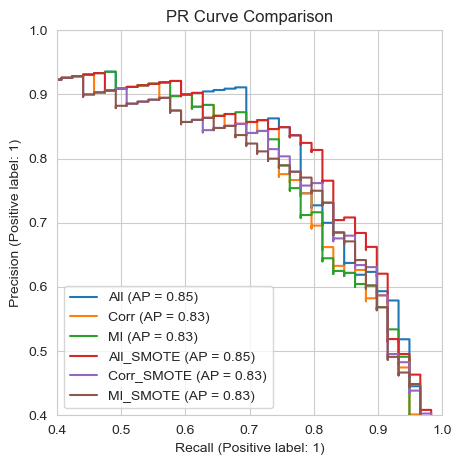

In [42]:
fig, ax = plt.subplots(figsize=(7, 5))

PrecisionRecallDisplay.from_estimator(model1, X_test1, y_test, ax=ax, name='All')
PrecisionRecallDisplay.from_estimator(model2, X_test2, y_test, ax=ax, name='Corr')
PrecisionRecallDisplay.from_estimator(model3, X_test3, y_test, ax=ax, name='MI')
PrecisionRecallDisplay.from_estimator(model1_2, X_test4, y_test, ax=ax, name='All_SMOTE')
PrecisionRecallDisplay.from_estimator(model2_2, X_test5, y_test, ax=ax, name='Corr_SMOTE')
PrecisionRecallDisplay.from_estimator(model3_2, X_test6, y_test, ax=ax, name='MI_SMOTE')

plt.xlim(0.4, 1)  
plt.ylim(0.4, 1)  
plt.title('PR Curve Comparison')
plt.show()

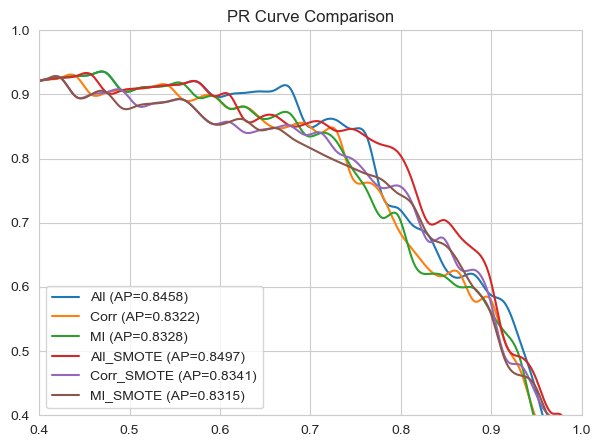

In [43]:
# PR Curve Smoothing + AP 4자리 출력 함수
def plot_smooth_pr(ax, model, X_test, y_test, label_name, color=None, linestyle='-'):
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    recall, idx = np.unique(recall, return_index=True)
    precision = precision[idx]

    recall_smooth = np.linspace(recall.min(), recall.max(), 1000)
    spl = make_interp_spline(recall, precision, k=3)
    precision_smooth = spl(recall_smooth)

    ap = average_precision_score(y_test, y_score)
    ax.plot(recall_smooth, precision_smooth, label=f'{label_name} (AP={ap:.4f})', linestyle=linestyle, color=color)

fig, ax = plt.subplots(figsize=(7, 5))

plot_smooth_pr(ax, model1, X_test1, y_test, 'All')
plot_smooth_pr(ax, model2, X_test2, y_test, 'Corr')
plot_smooth_pr(ax, model3, X_test3, y_test, 'MI')
plot_smooth_pr(ax, model1_2, X_test4, y_test, 'All_SMOTE')
plot_smooth_pr(ax, model2_2, X_test5, y_test, 'Corr_SMOTE')
plot_smooth_pr(ax, model3_2, X_test6, y_test, 'MI_SMOTE')

plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.title('PR Curve Comparison')
plt.legend()
plt.show()

AP(Average Precision, PR곡선의 아래면적)는 모든 변수+SMOTE를 적용한 모델이 가장 뛰어난 것을 알 수 있다.

In [53]:
results = [report_df1, report_df2, report_df3, report_df4, report_df5, report_df6]

model_names = ['All', 'Corr', 'MI', 'All_SMOTE', 'Corr_SMOTE', 'MI_SMOTE']

f1_scores = [df.loc['weighted avg', 'f1-score'] for df in results]  # 또는 'macro avg'

f1_df = pd.DataFrame({
    'Model': model_names,
    'F1-score': f1_scores
})

print(f1_df.sort_values(by='F1-score', ascending=False))

        Model  F1-score
0         All  0.956957
2          MI  0.952936
1        Corr  0.950893
3   All_SMOTE  0.919711
5    MI_SMOTE  0.914314
4  Corr_SMOTE  0.911634


weighted avg의 f1-score를 비교한 결과는 모든 변수를 넣고 모델을 생성했을때가 가장 점수가 좋았다

결론은, 전체적인 성능을 원한다면 모든 변수를 넣은 로지스틱 회귀 모델이 필요할 것이고,
소수 클래스의 예측이 중요하다면, 모든 변수를 넣은 뒤, SMOTE를 통해 데이터를 추가한 모델이 필요할 것이다. 

또한, 상관관계나 MI를 통해 특정 변수들만을 추린 뒤 모델을 생성했을 때 전반적으로 모델의 성능이 나빠지는 모습이 보였는데, 이는 다수의 변수들이 타겟 결정에 기여했다고 볼 수 있다.
이로부터 데이터 특성에 따라 feature selection이 항상 성능 향상에 기여한다고 볼 수 없다는 점을 알 수 있다.

이번에는 모든 변수를 넣은 데이터에 대해 VIF분석 후, 다중공선성이 모델의 성능 및 odds ratio에 끼치는 영향을 알아보고자 한다.
(이부분은 실패 했습니다)

In [85]:
corr_matrix_signed = X_train.corr()
corr_matrix_abs = corr_matrix_signed.abs()

# 1. 가장 Odds Ratio가 높았던 변수 5개 찾기
model_tmp = LogisticRegression(max_iter=1000)
model_tmp.fit(X_train, y_train)
odds_ratios = pd.Series(np.exp(model_tmp.coef_[0]), index=X_train.columns)
top_5_odds_features = odds_ratios.sort_values(ascending=False).head(5).index.tolist()

# 2. 각 변수별 상관관계가 높은 변수 5개 찾기 (중복, 이미 선택된 변수 제외)
corr_matrix = X_train.corr().abs()
related_features = set()
drop_feature_list = []


for feature in top_5_odds_features:
    high_corr_features = (
        corr_matrix[feature]
        .drop(index=feature)  # 자기 자신 제외
        .sort_values(ascending=False)
        .index.difference(top_5_odds_features)  # top 5 제외
        .difference(related_features)  # 중복 제외
        .tolist()[:1]
    )
    for related in high_corr_features:
        drop_feature_list.append({
            'Base Feature': feature,
            'Drop Feature': related,
            'Correlation': corr_matrix_signed.loc[feature, related]
        })
    
    related_features.update(high_corr_features)

drop_features = list(related_features)
drop_features_df = pd.DataFrame(drop_feature_list)


# 3. 변수 제거 후 데이터셋 구성
X_train_dropped = X_train.drop(columns=drop_features)
X_test_dropped = X_test1.drop(columns=drop_features)

# 제거 전 모델 학습
model_before = LogisticRegression(max_iter=1000)
model_before.fit(X_train, y_train)
odds_ratio_before = pd.Series(np.exp(model_before.coef_[0]), index=X_train.columns)

# 제거 후 모델 학습
model_after = LogisticRegression(max_iter=1000)
model_after.fit(X_train_dropped, y_train)
odds_ratio_after = pd.Series(np.exp(model_after.coef_[0]), index=X_train_dropped.columns)

# Odds Ratio 비교 (Top 5 변수만)
odds_ratio_change = pd.DataFrame({
    'Odds Ratio Before': odds_ratio_before[top_5_odds_features],
    'Odds Ratio After': odds_ratio_after[top_5_odds_features]
})

In [86]:
print(drop_feature_list)
print(odds_ratio_change)

[{'Base Feature': 'Garage Area', 'Drop Feature': '1st Flr SF', 'Correlation': 0.47661240441661434}, {'Base Feature': 'Mas Vnr Area', 'Drop Feature': '2nd Flr SF', 'Correlation': 0.1449939674410188}, {'Base Feature': 'Gr Liv Area', 'Drop Feature': '3Ssn Porch', 'Correlation': 0.010382392561655403}, {'Base Feature': 'Total Bsmt SF', 'Drop Feature': 'Bedroom AbvGr', 'Correlation': 0.04985961381614235}, {'Base Feature': 'BsmtFin SF 1', 'Drop Feature': 'Bldg Type_2fmCon', 'Correlation': 0.01876395975876952}]
               Odds Ratio Before  Odds Ratio After
Garage Area             1.004625          1.004598
Mas Vnr Area            1.002685          1.002549
Gr Liv Area             1.001538          1.002321
Total Bsmt SF           1.001444          1.001586
BsmtFin SF 1            1.001108          1.001083
